In [66]:
import matplotlib.image as mpimg
import os
  
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split
import PIL.Image as Image
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
import cv2
import PIL
import warnings
warnings.filterwarnings('ignore')

In [67]:
import pathlib
data_dir = "/kaggle/input/animal-image-datasetdog-cat-and-panda/animals/animals"
data_dir = pathlib.Path(data_dir)


In [68]:
# As stated,dataset has 3 classes: dogs, panda and cats.
for image_class in os.listdir(data_dir):
    
    print(image_class)

dogs
panda
cats


In [69]:
image_count = len(list(data_dir.glob('*/*.jpg')))  # more than 100 images per class.
print(image_count)

3000


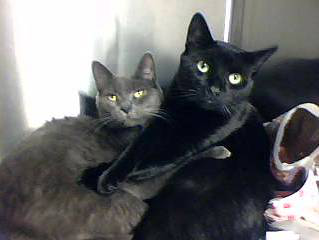

In [70]:
cats = list(data_dir.glob('cats/*'))
PIL.Image.open(str(cats[0]))

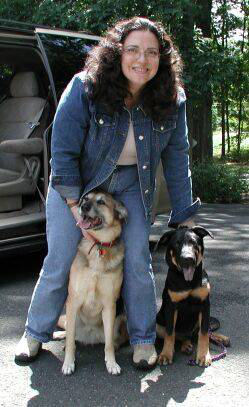

In [71]:
dogs = list(data_dir.glob('dogs/*'))
PIL.Image.open(str(dogs[1]))

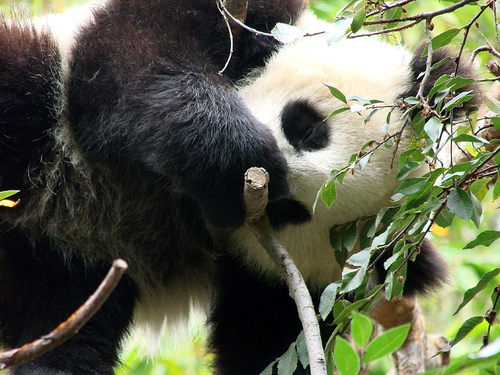

In [72]:
panda = list(data_dir.glob('panda/*'))
PIL.Image.open(str(panda[1]))

In [73]:
batch_size = 32
img_height = 180
img_width = 180

In [74]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.


In [75]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3000 files belonging to 3 classes.
Using 600 files for validation.


In [76]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs', 'panda']


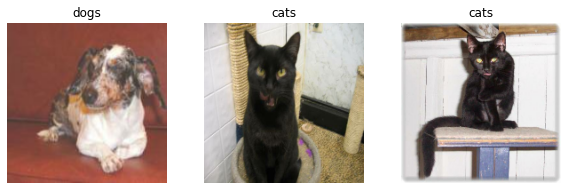

In [77]:
# visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [78]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [79]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [80]:
# input rescaled to [0,1] range 
normalization_layer = layers.Rescaling(1./255)

In [81]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0868985 0.9949918


In [82]:
num_classes = len(class_names)
num_classes

3

In [83]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [84]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 22, 22, 64)       

In [86]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
75/75 [==============================] - 21s 267ms/step - loss: 0.8445 - accuracy: 0.5625 - val_loss: 0.7032 - val_accuracy: 0.6833
Epoch 2/10
75/75 [==============================] - 18s 244ms/step - loss: 0.6240 - accuracy: 0.7083 - val_loss: 0.6831 - val_accuracy: 0.7017
Epoch 3/10
75/75 [==============================] - 19s 256ms/step - loss: 0.5252 - accuracy: 0.7588 - val_loss: 0.7343 - val_accuracy: 0.6900
Epoch 4/10
75/75 [==============================] - 18s 245ms/step - loss: 0.4293 - accuracy: 0.8121 - val_loss: 0.7019 - val_accuracy: 0.6867
Epoch 5/10
75/75 [==============================] - 19s 254ms/step - loss: 0.3508 - accuracy: 0.8425 - val_loss: 0.7464 - val_accuracy: 0.6933
Epoch 6/10
75/75 [==============================] - 19s 252ms/step - loss: 0.2639 - accuracy: 0.8908 - val_loss: 0.8421 - val_accuracy: 0.6983
Epoch 7/10
75/75 [==============================] - 18s 245ms/step - loss: 0.1648 - accuracy: 0.9450 - val_loss: 0.9278 - val_accuracy: 0.7050

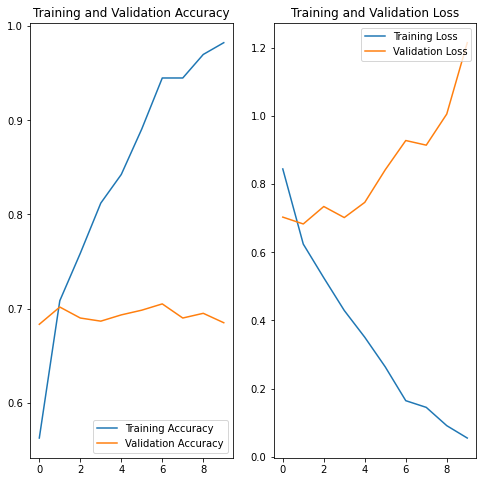

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [88]:
path = "/kaggle/input/animal-image-datasetdog-cat-and-panda/images/dog.jpg"
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to dogs with a 51.69 percent confidence.


In [128]:
from tensorflow.keras.applications.resnet50 import ResNet50


In [129]:
input_layer=layers.Input(shape=(img_height, img_width,3))
resnet_model=keras.applications.ResNet50(weights='imagenet',input_tensor=input_layer,include_top=False)

In [130]:
last_layer=resnet_model.output 
flatten=layers.Flatten()(last_layer) 

In [131]:
output_layer=layers.Dense(128,activation='relu')(flatten)
output_layer=layers.Dense(num_classes)(output_layer)

In [132]:
from tensorflow.keras import models
model=models.Model(inputs=input_layer,outputs=output_layer)

In [133]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 186, 186, 3)  0           input_21[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 90, 90, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [135]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
75/75 [==============================] - 516s 7s/step - loss: 2.1852 - accuracy: 0.6237 - val_loss: 1.2133 - val_accuracy: 0.4067
Epoch 2/10
75/75 [==============================] - 503s 7s/step - loss: 0.7386 - accuracy: 0.6879 - val_loss: 416.3149 - val_accuracy: 0.4483
Epoch 3/10
75/75 [==============================] - 496s 7s/step - loss: 0.4909 - accuracy: 0.7929 - val_loss: 0.4977 - val_accuracy: 0.7867
Epoch 4/10
75/75 [==============================] - 504s 7s/step - loss: 0.2734 - accuracy: 0.8867 - val_loss: 0.5140 - val_accuracy: 0.7833
Epoch 5/10
75/75 [==============================] - 498s 7s/step - loss: 0.1346 - accuracy: 0.9521 - val_loss: 0.6076 - val_accuracy: 0.7750
Epoch 6/10
75/75 [==============================] - 495s 7s/step - loss: 0.0998 - accuracy: 0.9683 - val_loss: 1.4301 - val_accuracy: 0.7150
Epoch 7/10
75/75 [==============================] - 493s 7s/step - loss: 0.0730 - accuracy: 0.9750 - val_loss: 1.5788 - val_accuracy: 0.7033
Epoch 8/10


In [ ]:
path = "/kaggle/input/animal-image-datasetdog-cat-and-panda/images/dog.jpg"
img = tf.keras.utils.load_img(
    path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)